In [1]:
#Import Relavent Python3 Libraries

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
def preprocessing_data(feature_path, labels_path=None):
    
    data_frame = pd.read_csv(feature_path, index_col=[0, 1, 2])
    
    # selecting best corelated features
    features = ['reanalysis_specific_humidity_g_per_kg', 
             'reanalysis_dew_point_temp_k', 
             'reanalysis_min_air_temp_k', 
             'station_min_temp_c']
    data_frame = data_frame[features]
    
    # fill missing values using interpolation
    data_frame.fillna(data_frame.interpolate(), inplace=True)

    # Data integration
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        data_frame = data_frame.join(labels)
    
    # separate san juan and iquitos cities
    sj = data_frame.loc['sj']
    iq = data_frame.loc['iq']
    
    return sj, iq

Calling the preprocessing methods on given data

# Reading the data files given from DrivenData

In [4]:
# File Names
feature_train_file_name = "dengue_features_train.csv"
labels_train_file_name = "dengue_labels_train.csv"

In [5]:
# File Locations
feature_train_file_loc = "Data/" + feature_train_file_name
labels_train_file_loc = "Data/" + labels_train_file_name

In [6]:
sj_train, iq_train = preprocessing_data(feature_train_file_loc, 
                                    labels_path=labels_train_file_loc)

In [7]:
sj_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,reanalysis_min_air_temp_k,station_min_temp_c,total_cases
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,16.546255,295.103507,297.297222,22.593803,34.180556
std,1.558857,1.567907,1.293459,1.505416,51.381372
min,11.715714,289.642857,292.600000,17.800000,0.000000
25%,15.225714,293.832857,296.300000,21.700000,9.000000
50%,16.832143,295.447143,297.500000,22.800000,19.000000
75%,17.854286,296.415714,298.400000,23.900000,37.000000
max,19.440000,297.795714,299.900000,25.600000,461.000000


In [8]:
iq_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,reanalysis_min_air_temp_k,station_min_temp_c,total_cases
count,520.000000,520.000000,520.000000,520.000000,520.000000
mean,17.101786,295.498441,292.876635,21.205673,7.565385
std,1.442356,1.413767,1.660695,1.261338,10.765478
min,12.111429,290.088571,286.900000,14.700000,0.000000
25%,16.121429,294.596429,292.000000,20.600000,1.000000
50%,17.435000,295.862857,293.100000,21.350000,5.000000
75%,18.180357,296.548571,294.200000,22.000000,9.000000
max,20.461429,298.450000,296.000000,24.200000,116.000000


Selecting the train data and test data from the dengue_features_train.csv file

In [9]:
sj_train_sub_train_data = sj_train.head(750)
sj_train_sub_test_data = sj_train.tail(sj_train.shape[0] - 750)

iq_train_sub_train_data = iq_train.head(400)
iq_train_sub_test_data = iq_train.tail(iq_train.shape[0] - 400)

In [10]:
def preprocessing_data(feature_path, labels_path=None):
    
    data_frame = pd.read_csv(feature_path, index_col=[0, 1, 2])
    
    # selecting best corelated features
    features = ['reanalysis_specific_humidity_g_per_kg', 
             'reanalysis_dew_point_temp_k', 
             'reanalysis_min_air_temp_k', 
             'station_min_temp_c']
    data_frame = data_frame[features]
    
    # fill missing values using interpolation
    data_frame.fillna(method='ffill', inplace=True)

    # Data integration
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        data_frame = data_frame.join(labels)
    
    # separate san juan and iquitos cities
    sj = data_frame.loc['sj']
    iq = data_frame.loc['iq']
    
    return sj, iq

In [11]:
sj_train, iq_train = preprocessing_data(feature_train_file_loc, 
                                    labels_path=labels_train_file_loc)

Finding the best Model

In [12]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
import statsmodels.genmod as sm
import numpy as np

def find_best_model(train, test):
#     Model formula
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "reanalysis_min_air_temp_k"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Finding the best Alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Use the entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = find_best_model(sj_train_sub_train_data, sj_train_sub_test_data)
iq_best_model = find_best_model(iq_train_sub_train_data, iq_train_sub_test_data)

best alpha =  1e-08
best score =  24.553763440860216
best alpha =  1e-08
best score =  6.441666666666666


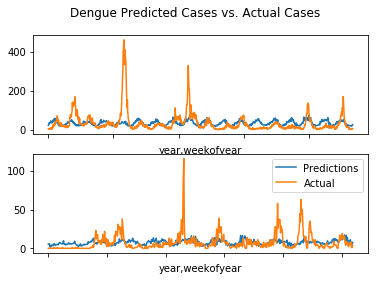

In [13]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [14]:
sj_test, iq_test = preprocessing_data("Data/dengue_features_test.csv")

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

In [15]:
submission = pd.read_csv("Data/submission_format.csv",index_col=[0,1,2])
labels_data = pd.read_csv(labels_train_file_loc,index_col=[0,1,2])

Ready the submission file

In [16]:
total_cases = sj_predictions + iq_predictions

In [17]:
submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("Data/results/predicted_results.csv")